In [3]:
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from moviepy import editor
import moviepy
import time

def dynamic_region_selection(image):
    """
    Dynamische Festlegung des Bereichs von Interesse (ROI) für die Fahrspurerkennung.
    Hier wird ein Trapez als Maske genutzt, das die relevante Region im Bild abdeckt.
    """
    rows, cols = image.shape[:2]  # Bildhöhe und -breite bestimmen

    # Definieren der Eckpunkte der ROI (unten breiter, oben schmaler)
    bottom_left = [cols * 0.1, rows * 0.85]  # Fast gesamte Breite unten
    top_left = [cols * 0.2, rows * 0.45]  # Schmaler Bereich oben
    bottom_right = [cols * 0.95, rows * 0.95]  # Rechts unten
    top_right = [cols * 0.9, rows * 0.5]  # Rechts oben

    # Erstellen der Polygonmaske für die ROI
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros_like(image)  # Schwarzes Bild als Maske
    cv2.fillPoly(mask, [vertices], 255)  # Maske mit weißem Polygon füllen
    masked_image = cv2.bitwise_and(image, mask)  # Bild mit Maske überlagern

    return masked_image  # Ergebnis zurückgeben

def frame_processor(image):
    """
    Verarbeitung eines einzelnen Frames: Kanten erkennen, Region beschränken und Fahrspuren identifizieren.
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Bild in Graustufen umwandeln
    blur = cv2.GaussianBlur(grayscale, (5, 5), 0)  # Weichzeichnen zur Rauschreduzierung
    edges = cv2.Canny(blur, 50, 150)  # Kantenerkennung mit Canny-Algorithmus

    region = dynamic_region_selection(edges)  # ROI anwenden

    # Morphologische Operation zum Schließen von Lücken zwischen Kanten
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(region, cv2.MORPH_CLOSE, kernel)

    # Konturen im Bild finden
    contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    output_image = image.copy()  # Kopie des Originalbilds für die Ausgabe
    height, width = image.shape[:2]
    middle_x = width // 2  # Bildmitte berechnen

    left_contour = None  # Platzhalter für die linke Fahrspur
    right_contour = None  # Platzhalter für die rechte Fahrspur

    if contours:
        # Konturen nach Größe sortieren (größte zuerst)
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

        for contour in sorted_contours:
            M = cv2.moments(contour)  # Schwerpunkt der Kontur berechnen
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])  # x-Koordinate des Schwerpunkts

                if cx < middle_x and left_contour is None:  # Linke Fahrspur
                    left_contour = contour
                elif cx >= middle_x and right_contour is None:  # Rechte Fahrspur
                    right_contour = contour

            if left_contour is not None and right_contour is not None:
                break  # Stoppen, wenn beide Spuren gefunden wurden

    # Gefundene Fahrspuren im Bild markieren
    if left_contour is not None:
        cv2.drawContours(output_image, [left_contour], -1, (255, 0, 0), 3)  # Blau für links
    if right_contour is not None:
        cv2.drawContours(output_image, [right_contour], -1, (255, 0, 0), 3)  # Grün für rechts

    return output_image  # Verarbeitetes Bild zurückgeben

def process_video(test_video, output_video):
    """
    Verarbeitung eines Videos: Fahrspuren in jedem Frame erkennen und speichern.
    Parameter:
        test_video: Pfad zum Eingabevideo.
        output_video: Speicherort für das Ausgabevideo.
    """
    input_video = editor.VideoFileClip(test_video, audio=False)  # Eingabevideo laden
    processed = input_video.fl_image(frame_processor)  # Verarbeitung jedes Frames
    processed.write_videofile(output_video, audio=False)  # Ausgabevideo speichern

# Hauptfunktion aufrufen
process_video('output_video_new.avi', 'output_video.mp4')

In [4]:
import time  # Zeitmessung

def frame_processing_time(image):
    """ Misst die Verarbeitungszeit für Graustufen, Blur, Canny Edge und ROI pro Frame """
    start_time = time.time()

    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Graustufen
    blur = cv2.GaussianBlur(grayscale, (5, 5), 0)  # Weichzeichnen
    edges = cv2.Canny(blur, 50, 150)  # Canny-Kantendetektion
    region = dynamic_region_selection(edges)  # ROI anwenden

    end_time = time.time()
    return end_time - start_time  # Dauer des Bildverarbeitungsprozesses zurückgeben

def process_video_time(test_video):
    """ Berechnet die Gesamtzeit für die Bildverarbeitung des gesamten Videos """
    input_video = editor.VideoFileClip(test_video, audio=False)  # Video laden
    total_processing_time = 0  # Gesamte Verarbeitungszeit
    frame_count = 0  # Anzahl der Frames

    for frame in input_video.iter_frames():  # Alle Frames durchgehen
        total_processing_time += frame_processing_time(frame)
        frame_count += 1

    print(f"Gesamte Bildverarbeitungszeit: {total_processing_time:.4f} Sekunden")
    print(f"Durchschnittliche Verarbeitungszeit pro Frame: {total_processing_time / frame_count:.4f} Sekunden")

process_video_time('output_video_new.avi')

Gesamte Bildverarbeitungszeit: 1.4911 Sekunden
Durchschnittliche Verarbeitungszeit pro Frame: 0.0007 Sekunden


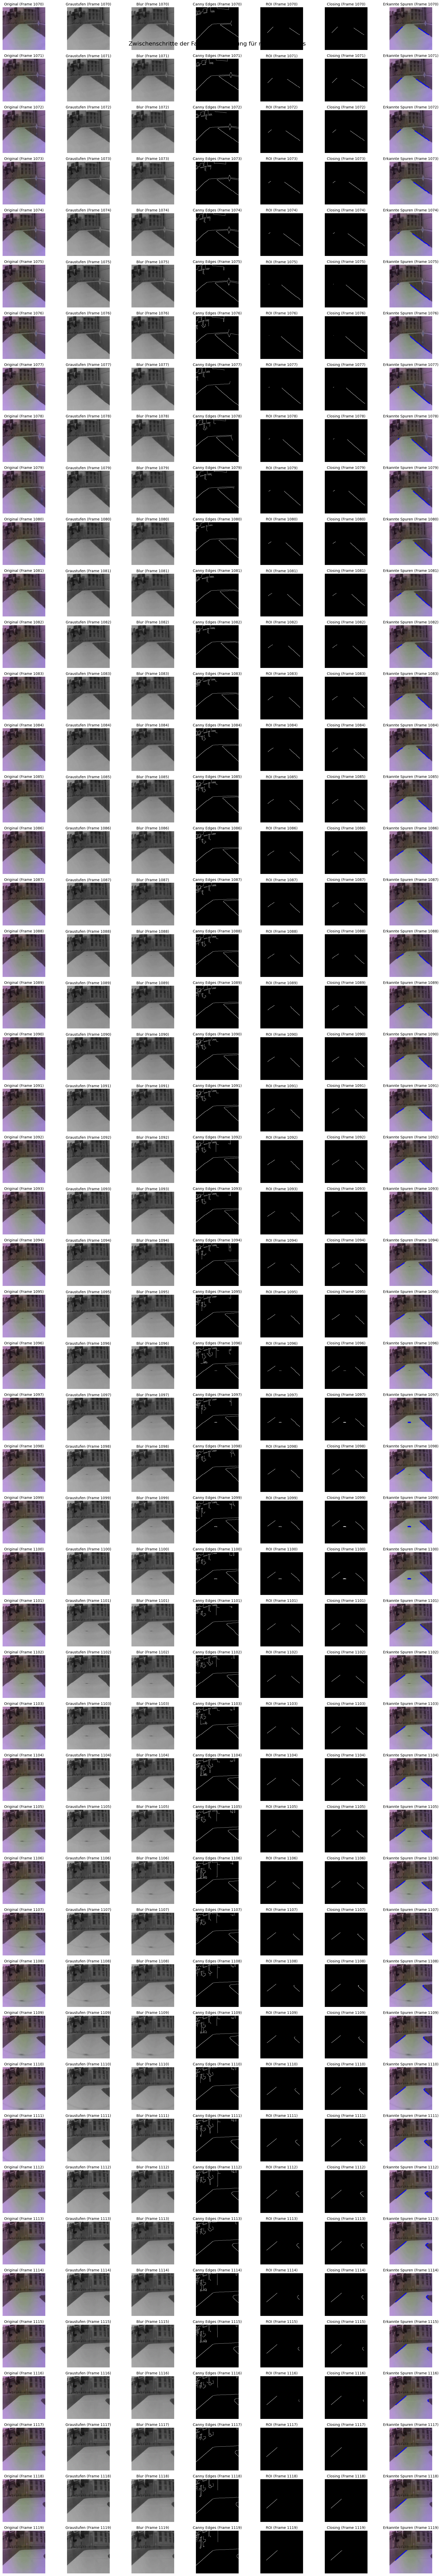

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip

def visualize_multiple_frames(video_path, num_frames=10):
    """ Visualisiert mehrere aufeinanderfolgende Frames aus der Mitte des Videos mit Zwischenschritten. """

    # Lade das Video
    video = VideoFileClip(video_path)
    fps = video.fps
    total_frames = int(video.fps * video.duration)

    # Starte in der Mitte des Videos und nehme `num_frames`
    start_frame = total_frames // 2 - num_frames // 2
    frame_indices = [start_frame + i for i in range(num_frames)]

    fig, axes = plt.subplots(num_frames, 7, figsize=(18, num_frames * 2))
    fig.suptitle("Zwischenschritte der Fahrspurerkennung für mehrere Frames", fontsize=16)

    # Titel für jede Spalte setzen
    titles = ["Original", "Graustufen", "Blur", "Canny Edges", "ROI", "Closing", "Erkannte Spuren"]

    for row, idx in enumerate(frame_indices):
        frame = video.get_frame(idx / fps)  # Frame aus Video holen

        # 1. Originalbild
        original = frame.copy()

        # 2. Graustufenbild
        grayscale = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

        # 3. Weichzeichnung (Gaussian Blur)
        blur = cv2.GaussianBlur(grayscale, (5, 5), 0)

        # 4. Kantenerkennung mit Canny
        edges = cv2.Canny(blur, 50, 150)

        # 5. Region of Interest (ROI)
        roi = dynamic_region_selection(edges)

        # 6. Morphologische Operation (Closing)
        kernel = np.ones((5, 5), np.uint8)
        closed = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel)

        # 7. Konturen & erkannte Fahrspuren
        processed = frame_processor(original)

        # Bildliste für die 7 Verarbeitungsschritte
        images = [original, grayscale, blur, edges, roi, closed, processed]

        for col, (img, title) in enumerate(zip(images, titles)):
            axes[row, col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[row, col].set_title(f"{title} (Frame {idx})", fontsize=10)
            axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()
    video.close()

# Aufruf der Funktion mit dem Pfad zum Video
visualize_multiple_frames("output_video_new.avi", num_frames=50)
